In [1]:
import numpy as np
import pandas as pd
x = pd.read_csv('Data/X.tsv', delimiter='\t', header=None).values

In [2]:
import tqdm
from Model import *
model = Model.Initialize('vae', x, pretrained_path  =r'..\Models\vae.pt')

Loading the pretrained model...


In [3]:
from sklearn.cluster import KMeans
num_clusters = 8

rep = model.Encode(x)
kmeans = KMeans(n_clusters = num_clusters).fit(rep)

In [4]:
from eldr.plotter.myplot import *

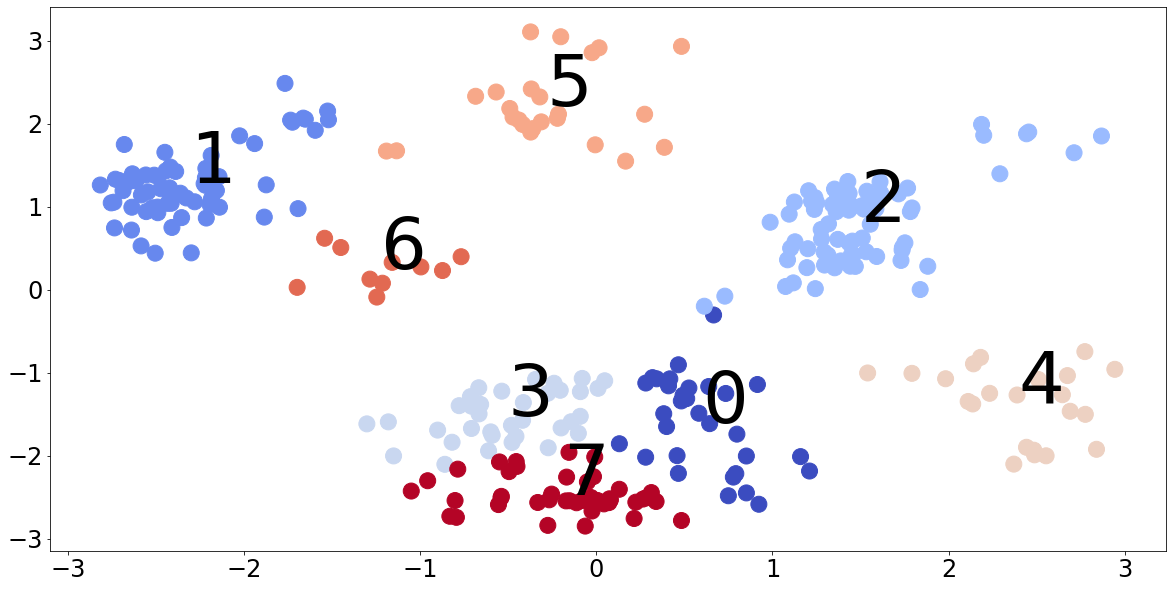

In [5]:
means, centers, indices = plot_groups(x, rep.numpy(), num_clusters, kmeans.labels_, name = "./synth-rep.png")

In [6]:
from eldr.explain.explain_cs import *

In [7]:
# Set epsilon for our metrics
epsilon = 0.5

Explainer = Explain(model, means, centers)

if True:
    Explainer.eval_epsilon(torch.tensor(x), indices, epsilon)

C:\Users\aukee\miniconda3\lib\site-packages\torch\nn\modules\container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


In [8]:
# initial_deltas = np.zeros((num_clusters - 1, means.shape[1]))
# for i in range(1, num_clusters):
#     initial_deltas[i - 1,:] = means[i,:] - means[0,:]

In [9]:
import os
import json
from types import SimpleNamespace
ntrials = 5
lg = 1.5
config = SimpleNamespace(**json.load(open(r'..\configs\tgt.json', 'r')))
ks = [1, 3, 5, 7, 9, 11, 13]

In [10]:
for k in ks:
    best_val = 0.0
    filename = str(k) + "-deltas.npy"
    for i in range(ntrials):
        print("Trial: ", i)
        Explainer = Explain(model, means, centers)
        deltas, tgt = Explainer.explain(config)#model, means, centers, learning_rate = 0.01, consecutive_steps = 5, init_mode='mean', lambda_global = lg)
        # print("Deltas: ", deltas)
        a, b = Explainer.metrics(torch.tensor(x), indices, deltas, epsilon)

        val = np.mean(a)

        if val > best_val:
            best_val = val
            print("best_val ", best_val, "deltas ", deltas)
            np.save(filename, deltas)

    os.system("rm -rf explanation")

Trial:  0
zero
[Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True), Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True), Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True), Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True), Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True), Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True), Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)]
Retrieving the best deltas...
iter: 0, ema: 2.1866276264190674, initial 1, target 6
Retrieving the best deltas...
iter: 2, ema: 2.1814098106622692, initial 1, target 6
Retrieving the best deltas...
iter: 3, 

C:\Users\aukee\miniconda3\lib\site-packages\torch\nn\modules\container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
C:\Users\aukee\miniconda3\lib\site-packages\torch\autograd\__init__.py:202: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return Variable._execution_engine.run_backward(
C:\Users\aukee\miniconda3\lib\site-packages\torch\nn\modules\container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
C:\Users\aukee\miniconda3\lib\site-packages\torch\nn\modules\container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on Param

np.set_printoptions(formatter={'float_kind':'{:f}'.format})
deltas = np.load("deltas.npy")
print("initial_deltas \n", initial_deltas, '\n')
print(deltas)

C:\Users\aukee\miniconda3\lib\site-packages\torch\nn\modules\container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
C:\Users\aukee\Documents\Artificial Intelligence\FACT\FACT-main\eldr\plotter\myplot.py:104: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)
C:\Users\aukee\miniconda3\lib\site-packages\mpl_toolkits\axes_grid1\axes_grid.py:46: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


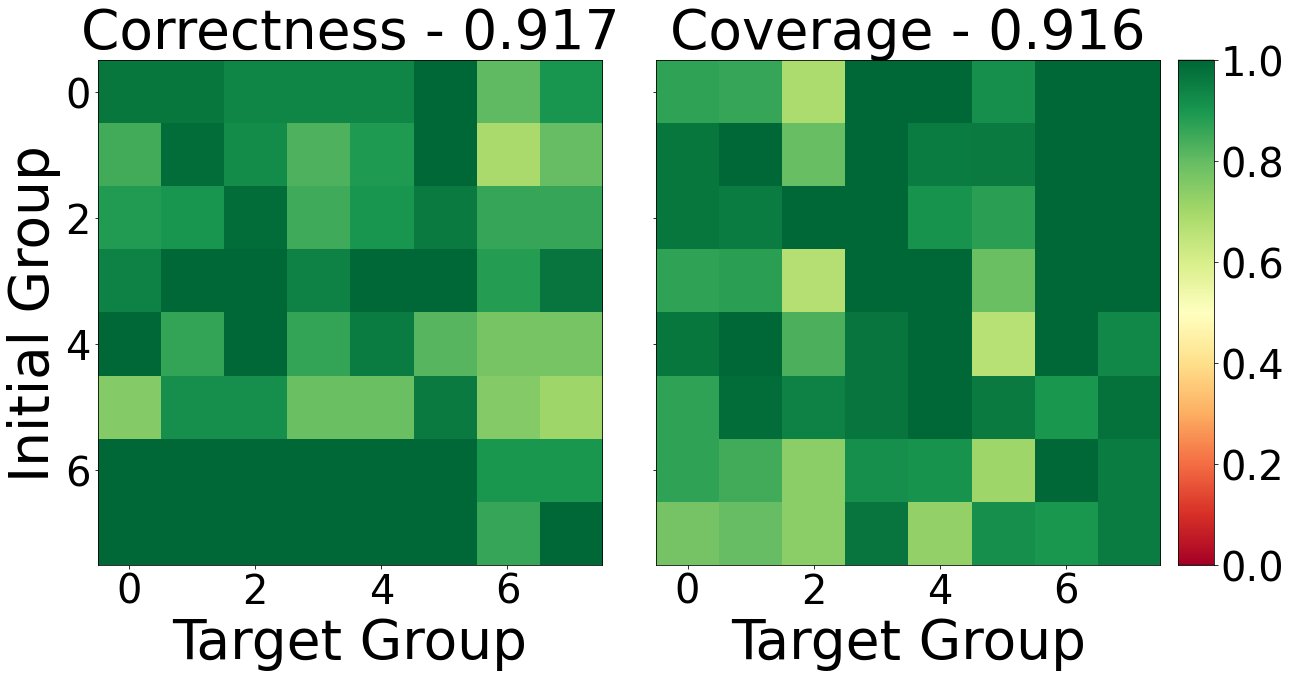

In [11]:
# Evaluate the explanations
deltas = np.load("13-deltas.npy")

a, b = Explainer.metrics(torch.tensor(x), indices, torch.from_numpy(deltas), epsilon)

plot_metrics(a, b, name = "synth-metrics-ours.png")

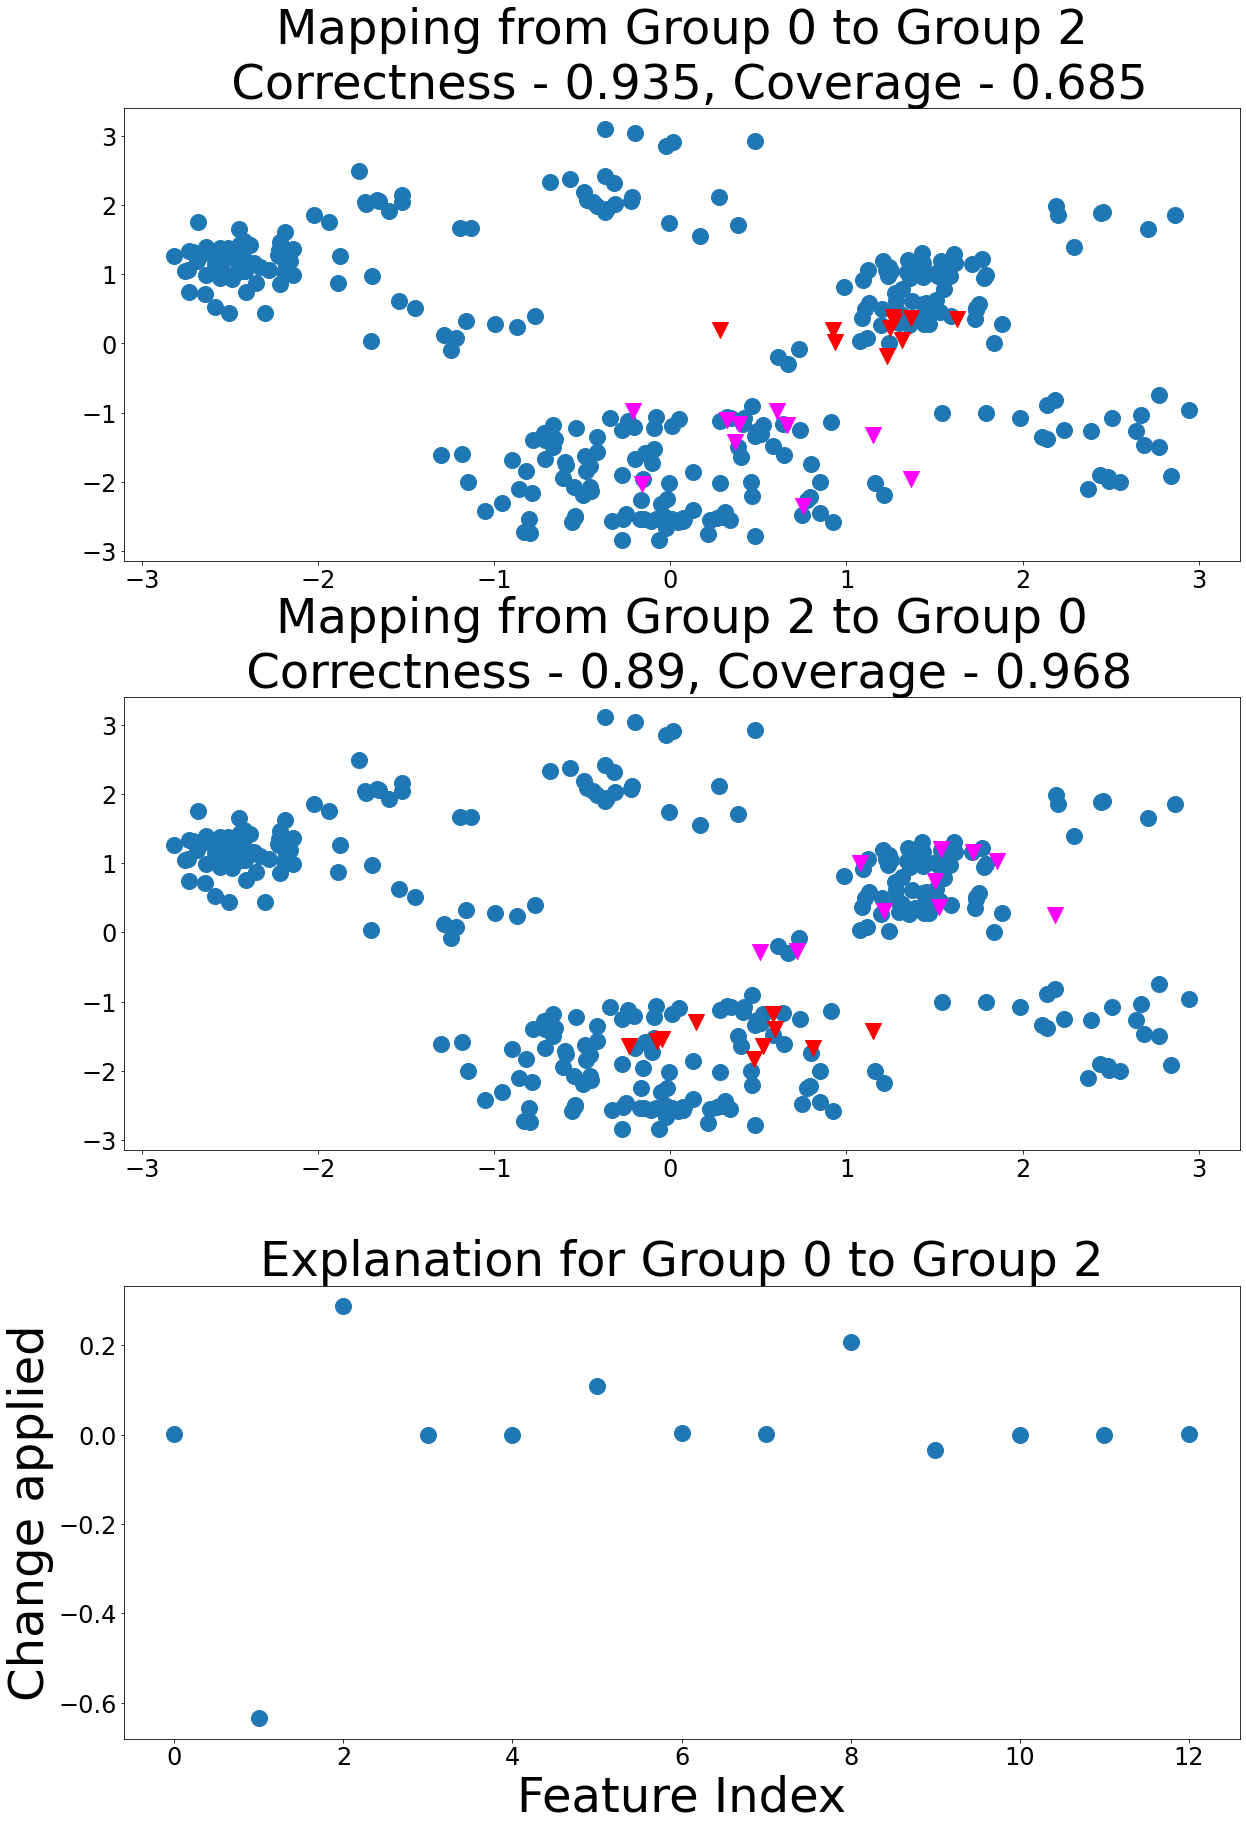

In [12]:
plot_explanation(model, x, rep, indices, deltas, a, b, 0, 2, num_points = 10, name = "tst_synthetic.png")

In [13]:
tgt_cors = []
tgt_covs = []
tgt_d = []
ks = [1, 3, 5, 7, 9, 11, 13]
for k in ks:
    filename = str(k) + "-deltas.npy"
    deltas = np.load(filename)
    cor, cov = Explainer.metrics(torch.tensor(x), indices, torch.from_numpy(deltas), epsilon, k=k)
    tgt_cors.append(np.mean(cor))
    tgt_covs.append(np.mean(cov))
    tgt_d.append(deltas)

C:\Users\aukee\miniconda3\lib\site-packages\torch\nn\modules\container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
C:\Users\aukee\miniconda3\lib\site-packages\torch\nn\modules\container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
C:\Users\aukee\miniconda3\lib\site-packages\torch\nn\modules\container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
C:\Users\aukee\miniconda3\lib\site-packages\torch\nn\modules\container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
C:\Users\aukee\miniconda3\lib\site-packages\torch\nn\modules\container.py:434: UserWarning: Setting attributes on ParameterL

In [14]:
sims = [0] * (len(ks) - 1)
for i in range(len(ks)-1):
    sim = [0] * len(tgt_d[0])
    for j in range(len(tgt_d[0])):
        sim[j] = (Explainer.similarity(tgt_d[i][j], tgt_d[i+1][j]))
    sims[i] = np.mean(sim)

print('done')

done


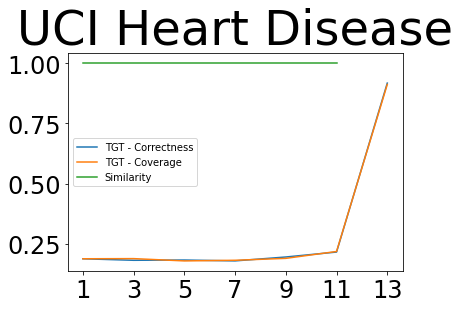

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(ks, tgt_cors, label = 'TGT - Correctness')
plt.plot(ks, tgt_covs, label = 'TGT - Coverage')
plt.plot(ks[:-1], sims, label = 'Similarity')
plt.title("UCI Heart Disease")
plt.xticks(ks)
plt.legend()
plt.show()
#%